# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data.
We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here.
You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)
* [6. Deep AutoEncoder](#6.-Deep-AutoEncoder)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 4882432/11490434 [===========>..................] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model architectures:

1. An encoder: a series of densly connected layers culminating in an "output" layer that determines the encoding dimensions.
2. A decoder: takes the output of the encoder as it's input and reconstructs the original data.
3. An autoencoder: a chain of the encoder and decoder that directly connects them for training purposes.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

The encoder and decoder are views to the first/last layers of the autoencoder model.
They'll be directly used in `transform` and `inverse_transform`, so we'll create some SciKeras models with those layers
and save them as in `encoder_model_` and `decoder_model_`. All three models are created within `_keras_build_fn`.

For a background on chaining Functional Models like this, see [All models are callable](https://keras.io/guides/functional_api/#all-models-are-callable-just-like-layers) in the Keras docs.

In [5]:
from typing import Dict, Any

from sklearn.base import TransformerMixin
from sklearn.metrics import mean_squared_error
from scikeras.wrappers import BaseWrapper


class AutoEncoder(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    encoder_model_: BaseWrapper
    decoder_model_: BaseWrapper
    
    def _keras_build_fn(self, encoding_dim: int, meta: Dict[str, Any]):
        n_features_in = meta["n_features_in_"]

        encoder_input = keras.Input(shape=(n_features_in,))
        encoder_output = keras.layers.Dense(encoding_dim, activation='relu')(encoder_input)
        encoder_model = keras.Model(encoder_input, encoder_output)

        decoder_input = keras.Input(shape=(encoding_dim,))
        decoder_output = keras.layers.Dense(n_features_in, activation='sigmoid', name="decoder")(decoder_input)
        decoder_model = keras.Model(decoder_input, decoder_output)
        
        autoencoder_input = keras.Input(shape=(n_features_in,))
        encoded_img = encoder_model(autoencoder_input)
        reconstructed_img = decoder_model(encoded_img)

        autoencoder_model = keras.Model(autoencoder_input, reconstructed_img)

        self.encoder_model_ = BaseWrapper(encoder_model, verbose=self.verbose)
        self.decoder_model_ = BaseWrapper(decoder_model, verbose=self.verbose)

        return autoencoder_model
    
    def _initialize(self, X, y=None):
        X, _ = super()._initialize(X=X, y=y)
        # since encoder_model_ and decoder_model_ share layers (and their weights)
        # X_tf here come from random weights, but we only use it to initialize our models
        X_tf = self.encoder_model_.initialize(X).predict(X)
        self.decoder_model_.initialize(X_tf)
        return X, X

    def initialize(self, X):
        self._initialize(X=X, y=X)
        return self

    def fit(self, X, *, sample_weight=None) -> "AutoEncoder":
        super().fit(X=X, y=X, sample_weight=sample_weight)
        # at this point, encoder_model_ and decoder_model_
        # are both "fitted" because they share layers w/ model_
        # which is fit in the above call
        return self

    def score(self, X) -> float:
        # Note: we use 1-MSE as the score
        # With MSE, "larger is better", but Scikit-Learn
        # always maximizes the score (e.g. in GridSearch)
        return 1 - mean_squared_error(self.predict(X), X)

    def transform(self, X) -> np.ndarray:
        X: np.ndarray = self.feature_encoder_.transform(X)
        return self.encoder_model_.predict(X)

    def inverse_transform(self, X_tf: np.ndarray):
        X: np.ndarray = self.decoder_model_.predict(X_tf)
        return self.feature_encoder_.inverse_transform(X)

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done.
We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [6]:
autoencoder = AutoEncoder(
    loss="binary_crossentropy",
    encoding_dim=32,
    random_state=0,
    epochs=5,
    verbose=False,
    optimizer="adam",
)

## 4. Training

To train the model, we pass the input images as both the features and the target.
This will train the layers to compress the data as accurately as possible between the encoder and decoder.
Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [7]:
_ = autoencoder.fit(X=x_train)

Next, we round trip the test dataset and explore the performance of the autoencoder.

In [8]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

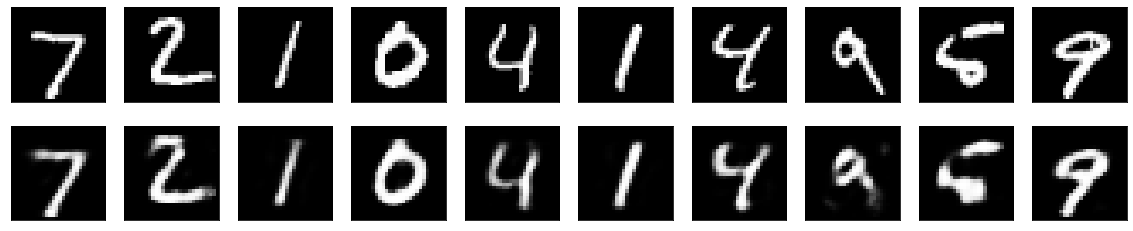

In [9]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [10]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test size (in MB): {x_test.nbytes/1024**2:.2f}")
print(f"encoded_imgs size (in MB): {encoded_imgs.nbytes/1024**2:.2f}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test size (in MB): 29.91
encoded_imgs size (in MB): 1.22
Compression ratio: 1/25


## 6. Deep AutoEncoder

We can easily expand our model to be a deep autoencoder by adding some hidden layers. All we have to do is add a parameter `hidden_layer_sizes` and use it in `_keras_build_fn` to build hidden layers.
For simplicity, we use a single `hidden_layer_sizes` parameter and mirror it across the encoding layers and decoding layers, but there is nothing forcing us to build symetrical models.

In [11]:
from typing import List


class DeepAutoEncoder(AutoEncoder):
    """A class that enables transform and fit_transform.
    """
    
    def _keras_build_fn(self, encoding_dim: int, hidden_layer_sizes: List[str], meta: Dict[str, Any]):
        n_features_in = meta["n_features_in_"]

        encoder_input = keras.Input(shape=(n_features_in,))
        x = encoder_input
        for layer_size in hidden_layer_sizes:
            x = keras.layers.Dense(layer_size, activation='relu')(x)
        encoder_output = keras.layers.Dense(encoding_dim, activation='relu')(x)
        encoder_model = keras.Model(encoder_input, encoder_output)

        decoder_input = keras.Input(shape=(encoding_dim,))
        x = decoder_input
        for layer_size in reversed(hidden_layer_sizes):
            x = keras.layers.Dense(layer_size, activation='relu')(x)
        decoder_output = keras.layers.Dense(n_features_in, activation='sigmoid', name="decoder")(x)
        decoder_model = keras.Model(decoder_input, decoder_output)

        autoencoder_input = keras.Input(shape=(n_features_in,))
        encoded_img = encoder_model(autoencoder_input)
        reconstructed_img = decoder_model(encoded_img)

        autoencoder_model = keras.Model(autoencoder_input, reconstructed_img)

        self.encoder_model_ = BaseWrapper(encoder_model, verbose=self.verbose)
        self.decoder_model_ = BaseWrapper(decoder_model, verbose=self.verbose)

        return autoencoder_model

In [12]:
deep = DeepAutoEncoder(
    loss="binary_crossentropy",
    encoding_dim=32,
    hidden_layer_sizes=[128],
    random_state=0,
    epochs=5,
    verbose=False,
    optimizer="adam",
)
_ = deep.fit(X=x_train)

In [13]:
print("1-MSE for training set (higher is better)\n")
score = autoencoder.score(X=x_test)
print(f"AutoEncoder: {score:.4f}")

score = deep.score(X=x_test)
print(f"Deep AutoEncoder: {score:.4f}")

1-MSE for training set (higher is better)



AutoEncoder: 0.9899


Deep AutoEncoder: 0.9901


Suprisingly, our score got worse. It's possible that that because of the extra trainable variables, our deep model trains slower than our simple model.

Check out the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) to see the difference after 100 epochs of training, as well as more architectures and applications for AutoEncoders!